In [1]:
import emcee, os, pygtc
import numpy as np, matplotlib.pyplot as plt
import os, numpy as np, matplotlib.pyplot as plt
from astropy.table import Table
os.environ['OMP_NUM_THREADS'] = "2"  ## each chain uses 1 thread

### disk contamination model

$$ \large
\mathcal{L}_i = \frac{1}{\sqrt{2 \pi (\sigma_i^2 + \sigma_{\mathrm{int}}^2})} 
    \exp\left[ -\frac{(C_i - \widehat{C}_i)^2}
    {2 (\sigma_i^2 + \sigma_{\mathrm{int}}^2)} \right]
$$
where
$$ \large
	\widehat{C}_i = \frac{D}{|\sin{b_i}|} + C^{\mathrm{halo}}.
$$

Data set: $\large b_i, C_i$ 

Parameters: $\large D, C^{\mathrm{halo}}, \sigma_{\mathrm{int}}$


In [3]:
def model(x, D, C):
    y = D/np.abs(np.sin(x*np.pi/180)) + C
    return y

def log_prior_IntScat(intscat):
    if intscat > 1e-3:
        #return 0
        return 1
    else:
        return -np.inf

def log_prior_D(D):
    if ( (D > -1) and (D < 2)):
        return 1
    else:
        return -np.inf

def log_prior_C(C):
    if ( (C > 0) and (C < 1) ):
        return 1
    else:
        return -np.inf

def log_likelihood(x, y, sigma, D, C, intscat):
    term1 = -0.5 * np.sum(np.log(2*np.pi*(sigma**2 + intscat**2)))
    chi2 = (y - model(x, D, C))**2 / (sigma**2 + intscat**2)
    term2 = -0.5 * np.sum(chi2)
    return term1 + term2

def log_posterior(params, xdata, ydata, sigdata):
    D = params[0]
    C = params[1]
    intscat = params[2] 

    lnP = log_likelihood(xdata, ydata, sigdata, D, C, intscat) +  log_prior_D(D) + log_prior_C(C) + log_prior_IntScat(intscat)
    # safeguard against NaNs: 
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP

### reading data

In [4]:
data = Table.read("res_ug.fits", format='fits')
fields_inside = [137, 160, 235, 374, 34, 236, 59, 98, 327, 174, 274]

data['inside'] = False
for i, field in enumerate(data['field']):
    if field in fields_inside:
        data['inside'][i] = True

inside = data['inside']
outside = ~data['inside']

b = np.array(data['b'])
c = np.array(data['SDSS_mode_x0'])
sigma = np.array((data['SDSS_mode_x0_up'] - data['SDSS_mode_x0_lo']) / 2 )

### set up the sampler

In [5]:
ndim = 3       # number of parameters in the model; here: D, C, intscat
nwalkers = 10  # number of MCMC walkers
nsteps = 2000  # number of MCMC steps to take

np.random.seed()
guess_D = np.random.random(nwalkers)
guess_C = np.random.random(nwalkers)
guess_intscat = 0.2 * np.random.random(nwalkers)

starting_guesses = np.column_stack((guess_D, guess_C, guess_intscat))

### run the sampler

In [6]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[b, c, sigma])
res = sampler.run_mcmc(starting_guesses, nsteps, progress='notebook') 
chains_raw = sampler.get_chain()

  0%|          | 0/2000 [00:00<?, ?it/s]

### plot the traces, decide on the burning stage

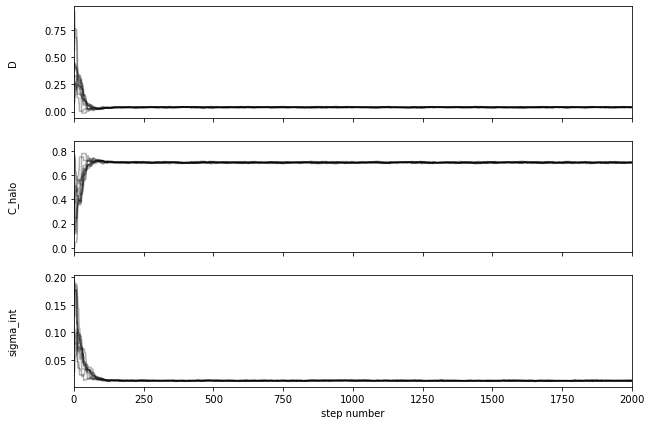

In [7]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = [r"D", r"C_halo", r"sigma_int"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(chains_raw[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains_raw))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### merge all chains into one chain and save

In [8]:
nburn = 250
chains = chains_raw[nburn:,:,:]
chains = chains.reshape(-1,3)

np.savetxt('chains_joint_emcee.dat', chains)

### better triangle plot using pygtc

In [9]:
chains_north = np.loadtxt('chains_sep_north.dat')
chains_south = np.loadtxt('chains_sep_south.dat') 
chains_joint = np.loadtxt('chains_joint.dat')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


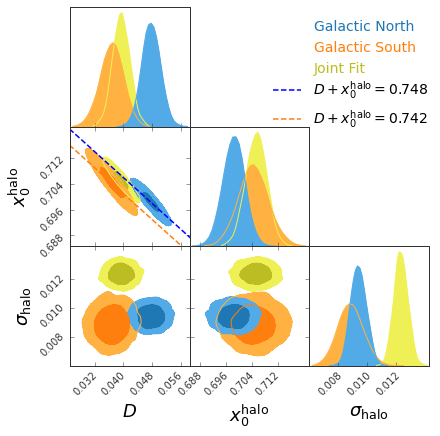

In [10]:
c_labels = ['Galactic North', 'Galactic South', 'Joint Fit']
mylabelfont = {'size':18}
mytickfont = {'size':10}
mylegendfont = {'size':14}
myparams = [r'$D$', r'$x_0^{\mathrm{halo}}$', r'$\sigma_\mathrm{halo}$']
mycolor = ['blues', 'oranges','yellows'] # ['greens', 'reds',  'browns', 'pinks', 'grays', 'yellows', 'cyans']
sdss_ranges = [(0.05, 0.11), (0.74, 0.82), (0.005,0.018)]
fig = pygtc.plotGTC(chains=[chains_north, chains_south, chains_joint], chainLabels=c_labels, paramNames=myparams,\
                    customTickFont=mytickfont, customLabelFont=mylabelfont, customLegendFont=mylegendfont, colorsOrder=mycolor, figureSize=6)


ax_list = fig.axes
ax = ax_list[0]

D_grid = np.linspace(0.02, 0.06, 100)
x0_grid = 0.746 - D_grid   ### 0.748 in the rounded D and C in Table 4; It really is 0.746
ax.plot(D_grid, x0_grid, 'b--', label=r'$D + x_0^{\mathrm{halo}} = 0.748$')

x0_grid = 0.741 - D_grid   ### 0.742 in the rounded D and C in Table 4; It really is 0.741
ax.plot(D_grid, x0_grid, 'C1--', label=r'$D + x_0^{\mathrm{halo}} = 0.742$')
ax.legend(frameon=False, prop={'size':14}, bbox_to_anchor=(3.1, 1.5))

plt.subplots_adjust(top=0.98, right=0.98, bottom=0.15, left=0.15)

### plot errorband

In [11]:
def disk_model(x, D, C):
    y = D/np.abs(np.sin(np.radians(x))) + C
    return y

def plot_errorbands(x, chains, ax, color, *args, **kwargs):

    D = chains[:,0]
    C = chains[:,1]
    int_scat = chains[:,2]

    #print(np.median(D), np.median(C), np.median(int_scat))

    N_data = len(x)                            ## number of data points
    N_iter = len(D)                            ## number of iteration; each iteration gives a model curve
    y_sct = np.zeros((N_iter, N_data))         ## each model curve predicts a set of y on x
  
    for i in range(N_iter):                    ## y_sct is model plus intrinsic scatter
        y_sct[i,:] =  disk_model(x, D[i], C[i]) +  np.random.normal(0, int_scat[i], N_data) 

    y50 = np.median(y_sct, axis=0)             ## median = best fit
    
    y84 = np.percentile(y_sct, 84, axis=0)     ## 1 sigma upper
    y16 = np.percentile(y_sct, 16, axis=0)     ## 1 sigma lower

    y975 = np.percentile(y_sct, 97.5, axis=0)  ## 2 sigma upper
    y25 = np.percentile(y_sct, 2.5, axis=0)    ## 2 sigma lower

    line, = ax.plot(x, y50, color, *args, **kwargs)
    ax.fill_between(x, y84, y16, alpha=0.25, color=line.get_color())
    ax.fill_between(x, y975, y25, alpha=0.25, color=line.get_color())

def plot_median(x, chains, ax, color, *args, **kwargs):

    D = chains[:,0]
    C = chains[:,1]
    int_scat = chains[:,2]

    N_data = len(x)                            ## number of data points
    N_iter = len(D)                            ## number of iteration; each iteration gives a model curve
    y_sct = np.zeros((N_iter, N_data))         ## each model curve predicts a set of y on x
  
    for i in range(N_iter):                    ## y_sct is model plus intrinsic scatter
        y_sct[i,:] =  disk_model(x, D[i], C[i]) +  np.random.normal(0, int_scat[i], N_data) 

    y50 = np.median(y_sct, axis=0)             ## median = best fit

    line, = ax.plot(x, y50, color, *args, **kwargs)


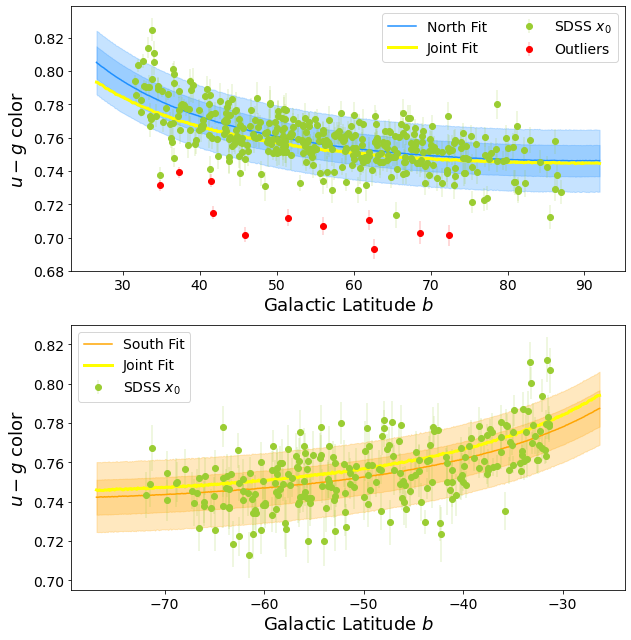

In [12]:
data = Table.read("res_ug.fits", format='fits')
fields_inside = [137, 160, 235, 374, 34, 236, 59, 98, 327, 174, 274]

data['inside'] = False
for i, field in enumerate(data['field']):
    if field in fields_inside:
        data['inside'][i] = True

b = np.array(data['b'])
c = np.array(data['SDSS_mode_x0'])
sigma = np.array((data['SDSS_mode_x0_up'] - data['SDSS_mode_x0_lo']) / 2 )

chains_north = np.loadtxt('chains_sep_north.dat')
chains_south = np.loadtxt('chains_sep_south.dat') 
chains_joint = np.loadtxt('chains_joint.dat') 

##############################################################################

fig = plt.figure(figsize=(9,9))
ax1 = plt.subplot(211)
ax1.set_xlabel(r'Galactic Latitude $b$', fontsize=18)
ax1.set_ylabel(r'$u-g$ color', fontsize=18)
ax2 = plt.subplot(212)
ax2.set_xlabel(r'Galactic Latitude $b$', fontsize=18)
ax2.set_ylabel(r'$u-g$ color', fontsize=18)

############### North ###############
ind, = np.where( (b>30) & ~data['inside'] ) # North non-cluster data
xgrid_north = np.linspace(b[ind].min()-5, b[ind].max()+5, 500)

ax1.errorbar(b[ind], c[ind], yerr=sigma[ind], fmt="o", c='yellowgreen', linewidth=0.3, label=r'SDSS $x_0$')
ax1.errorbar(b[data['inside']], c[data['inside']], yerr=sigma[data['inside']], fmt="o", c='red', linewidth=0.3, label='Outliers')
plot_errorbands(xgrid_north, chains_north, ax1, 'dodgerblue', label='North Fit')
plot_median(xgrid_north, chains_joint, ax1, 'yellow', linewidth=3, label='Joint Fit')

############### South ###############
ind, = np.where( (b<-30) ) # South non-cluster data
xgrid_south = np.linspace(b[ind].min()-5, b[ind].max()+5, 500)

ax2.errorbar(b[ind], c[ind], yerr=sigma[ind], fmt="o", c='yellowgreen', linewidth=0.3, label=r'SDSS $x_0$')
plot_errorbands(xgrid_south, chains_south, ax2, 'orange', label='South Fit')
plot_median(xgrid_south, chains_joint, ax2, 'yellow', linewidth=3, label='Joint Fit')

ax1.legend(prop={'size': 14}, ncol=2)
ax2.legend(prop={'size': 14}, loc='upper left')

ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

plt.tight_layout()
